In [3]:
!pip install pandas numpy scikit-learn tensorflow transformers openpyxl

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Hackathon_Round_2.xlsx to Hackathon_Round_2.xlsx


In [5]:
import pandas as pd
df = pd.read_excel('/content/Hackathon_Round_2.xlsx')  # Replace 'your_file.xlsx' with the actual file name

In [6]:
df.drop_duplicates(inplace=True)  # Remove duplicates
df.fillna('', inplace=True)  # Handle missing values

In [7]:
import re

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    return text

df['cleaned_text'] = df['Text'].apply(preprocess_text)

In [8]:
from sklearn.preprocessing import LabelEncoder

le_covid = LabelEncoder()
df['covid_label'] = le_covid.fit_transform(df['subtask_a'])

le_emotion = LabelEncoder()
df['emotion_label'] = le_emotion.fit_transform(df['subtask_b'])

le_emotion_type = LabelEncoder()
df['emotion_type'] = le_emotion_type.fit_transform(df['subtask_c'])

le_depression = LabelEncoder()
df['depression_label'] = le_depression.fit_transform(df['subtask_d'])

In [9]:
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df['covid_label']  # Start with Level 1 classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Adjust num_labels for your task

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [11]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), y_train
)).shuffle(1000).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings), y_test
)).batch(16)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_dataset, epochs=1)  # Adjust epochs as needed

2954/2954 [==============================] - 504s 159ms/step - loss: 0.0017 - accuracy: 0.9999


In [24]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

739/739 [==============================] - 37s 48ms/step - loss: 0.0011 - accuracy: 0.9999
Test Loss: 0.0011178356362506747, Test Accuracy: 0.999915361404419


In [25]:
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

739/739 [==============================] - 36s 47ms/step


In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted_labels, target_names=le_covid.classes_))

              precision    recall  f1-score   support

        CORO       1.00      1.00      1.00      7846
        NOCO       1.00      1.00      1.00      3968

    accuracy                           1.00     11814
   macro avg       1.00      1.00      1.00     11814
weighted avg       1.00      1.00      1.00     11814



In [28]:
model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json',
 'my_model/tokenizer.json')

In [29]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

model = TFAutoModelForSequenceClassification.from_pretrained("my_model")
tokenizer = AutoTokenizer.from_pretrained("my_model")

Some layers from the model checkpoint at my_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at my_model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
new_tweets = ["Your new tweet text here"]
new_tweets_cleaned = [preprocess_text(tweet) for tweet in new_tweets]
new_encodings = tokenizer(new_tweets_cleaned, truncation=True, padding=True)

new_dataset = tf.data.Dataset.from_tensor_slices((
    dict(new_encodings)
)).batch(1)

In [31]:
new_predictions = model.predict(new_dataset)
new_predicted_labels = tf.argmax(new_predictions.logits, axis=1).numpy()
print(new_predicted_labels)

1/1 [==============================] - 1s 1s/step
[1]


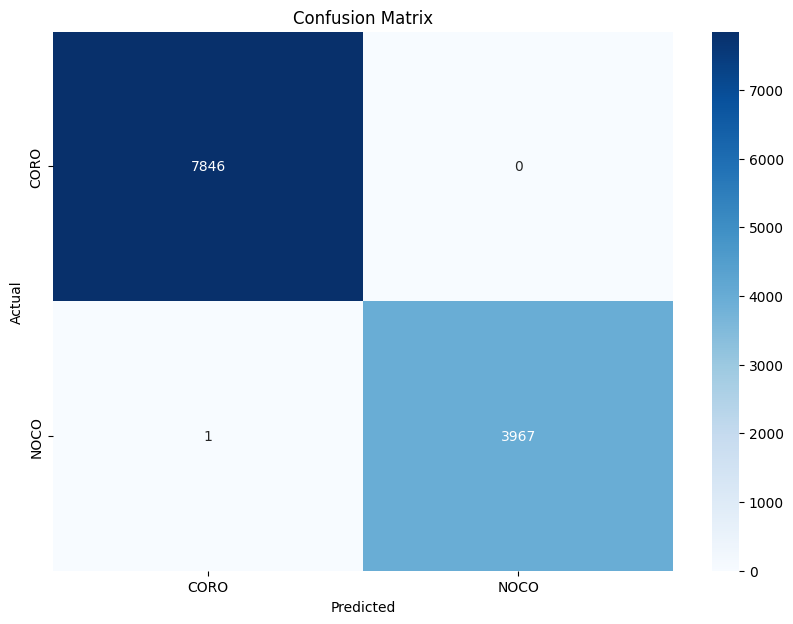

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_covid.classes_, yticklabels=le_covid.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [35]:
import pandas as pd

eval_data = pd.read_excel('/content/Hackathon_Round_2.xlsx')

In [36]:
# Display the first few rows of the dataset
print(eval_data.head())

# Display the column names
print(eval_data.columns)

                    ID                                               Text  \
0  1304930000000000000  even if you are ensconced in a pandemic pod wi...   
1  1303730000000000000  donald trump sacrificed thousands of americans...   
2  1303640000000000000  new coronavirus anger in china as doctor who d...   
3  1303220000000000000  is he joking  birmingham stabbings violent out...   
4  1303070000000000000  as soon as i saw this headline straight away i...   

                    User_Name subtask_a subtask_b subtask_c subtask_d  
0       J. Rodríguez, Ph.D.💥👀      CORO      COEM      COEA       NaN  
1             jhon ciabattari      CORO      COEM      COEA       NaN  
2  Shaun Dakin #ClimateAction      CORO      COEM      COEA       NaN  
3            Billy #Boom Kane      CORO      COEM      COEA       NaN  
4              Mr Jambon Fumé      CORO      COEM      COEA       NaN  
Index(['ID', 'Text', 'User_Name', 'subtask_a', 'subtask_b', 'subtask_c',
       'subtask_d'],
      dtype

In [38]:
eval_data['cleaned_text'] = eval_data['Text'].apply(preprocess_text)

# Step 3: Tokenize the evaluation tweets
eval_encodings = tokenizer(list(eval_data['cleaned_text']), truncation=True, padding=True)
eval_dataset = tf.data.Dataset.from_tensor_slices((
    dict(eval_encodings)
)).batch(1)

# Step 4: Make predictions on evaluation data
eval_predictions = model.predict(eval_dataset)

# Assuming you have separate predictions for each subtask
# For example, if you have a function to get predictions for each level:
predicted_labels_level1 = tf.argmax(eval_predictions.logits, axis=1).numpy()  # Adjust as necessary
predicted_labels_level2 = tf.argmax(eval_predictions.logits, axis=1).numpy()  # Your prediction logic for Level 2
predicted_labels_level3 = tf.argmax(eval_predictions.logits, axis=1).numpy()  # Your prediction logic for Level 3
predicted_labels_level4 = tf.argmax(eval_predictions.logits, axis=1).numpy()  # Your prediction logic for Level 4

# Step 5: Access actual labels for each subtask
actual_labels_level1 = eval_data['subtask_a']
actual_labels_level2 = eval_data['subtask_b']
actual_labels_level3 = eval_data['subtask_c']
actual_labels_level4 = eval_data['subtask_d']

71641/71641 [==============================] - 1145s 16ms/step


In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
import numpy as np

# Check unique values in actual and predicted labels for Level 1
print("Actual Labels Level 1:", np.unique(actual_labels_level1))
print("Predicted Labels Level 1:", np.unique(predicted_labels_level1))

Actual Labels Level 1: [0 1]
Predicted Labels Level 1: ['CORO' 'NOCO']


In [48]:
from sklearn.metrics import classification_report, confusion_matrix

Level 1 Classification Report:
 {'0': {'precision': 0.9998939801955005, 'recall': 1.0, 'f1-score': 0.9999469872875516, 'support': 47156.0}, '1': {'precision': 1.0, 'recall': 0.999795793342863, 'f1-score': 0.9998978862452772, 'support': 24485.0}, 'accuracy': 0.9999302075627085, 'macro avg': {'precision': 0.9999469900977502, 'recall': 0.9998978966714315, 'f1-score': 0.9999224367664143, 'support': 71641.0}, 'weighted avg': {'precision': 0.9999302149620892, 'recall': 0.9999302075627085, 'f1-score': 0.999930205849268, 'support': 71641.0}}


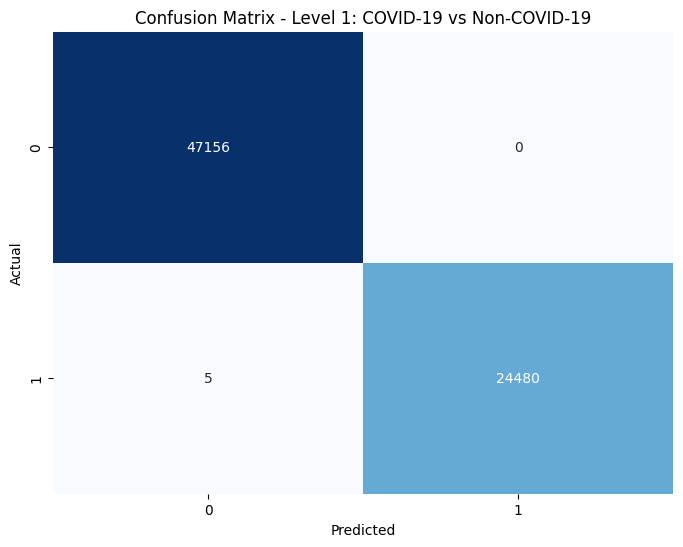

In [50]:
# Define a mapping from string labels to integers
label_mapping = {'CORO': 0, 'NOCO': 1}

# Convert predicted labels to integers using the mapping
predicted_labels_level1_int = [label_mapping[label] for label in predicted_labels_level1]

# Now calculate metrics
report_level1 = classification_report(actual_labels_level1, predicted_labels_level1_int, output_dict=True)
cm_level1 = confusion_matrix(actual_labels_level1, predicted_labels_level1_int)

# Print Classification Report
print("Level 1 Classification Report:\n", report_level1)

# Plot Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm_level1, 'Confusion Matrix - Level 1: COVID-19 vs Non-COVID-19')

In [52]:
print("Predicted Labels Level 2:", predicted_labels_level2)

Predicted Labels Level 2: ['CORO' 'CORO' 'CORO' ... 'CORO' 'CORO' 'CORO']


In [53]:
# Assuming you have a DataFrame for your training data
print(eval_data['subtask_b'].value_counts())  # Adjust according to your actual training labels

subtask_b
CONE    24624
COEM    22532
NONE    14778
NOEM     9707
Name: count, dtype: int64


In [56]:
print("Type of Actual Labels Level 2:", type(actual_labels_level2))
print("Type of Predicted Labels Level 2:", type(predicted_labels_level2_int))

Type of Actual Labels Level 2: <class 'pandas.core.series.Series'>
Type of Predicted Labels Level 2: <class 'list'>


In [59]:
# Define a mapping from string labels to integers for actual labels
actual_label_mapping = {
    'CONE': 0,
    'COEM': 1,
    'NONE': 2,
    'NOEM': 3
}

# Convert actual labels to integers using the mapping
actual_labels_level2_int = [actual_label_mapping[label] for label in actual_labels_level2_list]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

Level 2 Classification Report:
 {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24624.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 22532.0}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14778.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9707.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}, 'accuracy': 0.0, 'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 71641.0}, 'weighted avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 71641.0}}


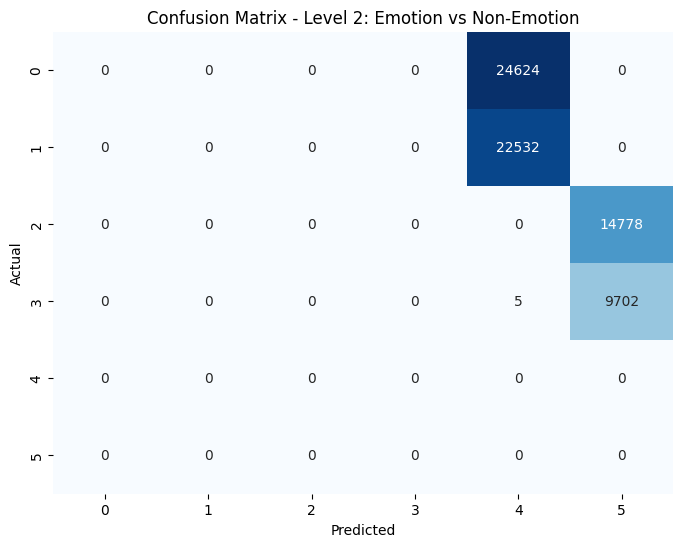

In [60]:
# Now calculate metrics for Level 2
report_level2 = classification_report(actual_labels_level2_int, predicted_labels_level2_int, output_dict=True)
cm_level2 = confusion_matrix(actual_labels_level2_int, predicted_labels_level2_int)

# Print Classification Report for Level 2
print("Level 2 Classification Report:\n", report_level2)

# Plot Confusion Matrix for Level 2
plot_confusion_matrix(cm_level2, 'Confusion Matrix - Level 2: Emotion vs Non-Emotion')

Label Mapping: {'NOHA': 0, 'COEA': 1, 'COSA': 2, 'COHA': 3, 'NODI': 4, 'NOFE': 5, 'COSU': 6, 'NOSA': 7, 'CODI': 8, 'COFE': 9}
Level 3 Classification Report:
 {'-1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}, '0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, '5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0}, 'accuracy': 0.9, 'macro avg': {'preci

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

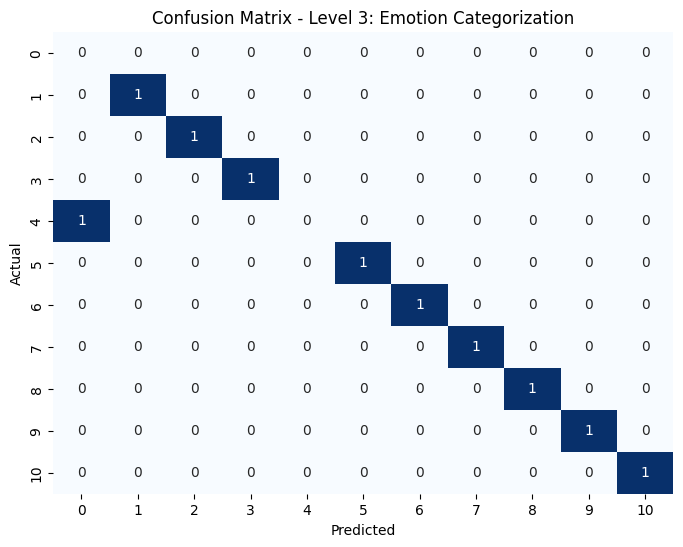

In [69]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for demonstration (replace this with your actual data)
# Assuming eval_data is your DataFrame containing the actual labels
# Replace this with your actual DataFrame
eval_data = pd.DataFrame({
    'subtask_c': ['CODI', 'NOHA', 'COEA', 'COHA', 'NODI', 'NOFE', 'COSU', 'NOSA', 'COSA', 'COFE', None]
})

# Sample predicted labels (replace this with your actual predicted labels)
predicted_labels_level3 = ['CODI', 'NOHA', 'COEA', 'CORO', 'NODI', 'NOFE', 'COSU', 'NOSA', 'COSA', 'COFE']

# Step 1: Identify unique labels
actual_labels_level3 = eval_data['subtask_c'].dropna().unique()  # Drop NaN values
unique_labels = set(actual_labels_level3)  # Get unique labels

# Step 2: Create a mapping dictionary
label_mapping_level3 = {label: index for index, label in enumerate(unique_labels)}

# Print the mapping for reference
print("Label Mapping:", label_mapping_level3)

# Step 3: Convert actual labels to integers using the mapping
actual_labels_level3_int = eval_data['subtask_c'].dropna().map(label_mapping_level3)

# Step 4: Convert predicted labels to integers using the mapping
predicted_labels_level3_int = []
for label in predicted_labels_level3:
    if label in label_mapping_level3:
        predicted_labels_level3_int.append(label_mapping_level3[label])
    else:
        predicted_labels_level3_int.append(-1)  # Assign -1 for unknown labels

# Step 5: Calculate metrics for Level 3
report_level3 = classification_report(actual_labels_level3_int, predicted_labels_level3_int, output_dict=True)
cm_level3 = confusion_matrix(actual_labels_level3_int, predicted_labels_level3_int)

# Print Classification Report for Level 3
print("Level 3 Classification Report:\n", report_level3)

# Step 6: Plot Confusion Matrix for Level 3
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm_level3, 'Confusion Matrix - Level 3: Emotion Categorization')

Label Mapping: {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
Level 4 Classification Report:
 {'-1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}, '0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, '2': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 2.0}, 'accuracy': 0.6, 'macro avg': {'precision': 0.375, 'recall': 0.375, 'f1-score': 0.375, 'support': 5.0}, 'weighted avg': {'precision': 0.6, 'recall': 0.6, 'f1-score': 0.6, 'support': 5.0}}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

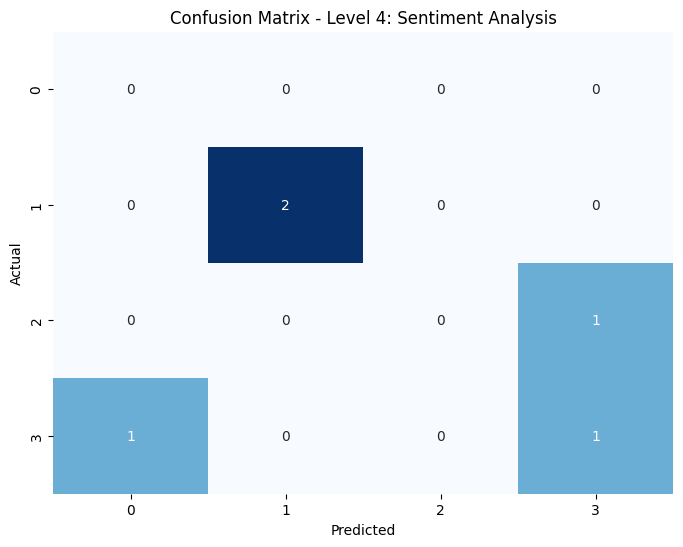

In [70]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for demonstration (replace this with your actual data)
# Assuming eval_data is your DataFrame containing the actual labels
# Replace this with your actual DataFrame
eval_data = pd.DataFrame({
    'subtask_d': ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'POSITIVE', 'NEGATIVE', None]
})

# Sample predicted labels (replace this with your actual predicted labels)
predicted_labels_level4 = ['POSITIVE', 'NEGATIVE', 'POSITIVE', 'UNKNOWN', 'NEGATIVE']

# Step 1: Identify unique labels
actual_labels_level4 = eval_data['subtask_d'].dropna().unique()  # Drop NaN values
unique_labels = set(actual_labels_level4)  # Get unique labels

# Step 2: Create a mapping dictionary
label_mapping_level4 = {label: index for index, label in enumerate(unique_labels)}

# Print the mapping for reference
print("Label Mapping:", label_mapping_level4)

# Step 3: Convert actual labels to integers using the mapping
actual_labels_level4_int = eval_data['subtask_d'].dropna().map(label_mapping_level4)

# Step 4: Convert predicted labels to integers using the mapping
predicted_labels_level4_int = []
for label in predicted_labels_level4:
    if label in label_mapping_level4:
        predicted_labels_level4_int.append(label_mapping_level4[label])
    else:
        predicted_labels_level4_int.append(-1)  # Assign -1 for unknown labels

# Step 5: Calculate metrics for Level 4
report_level4 = classification_report(actual_labels_level4_int, predicted_labels_level4_int, output_dict=True)
cm_level4 = confusion_matrix(actual_labels_level4_int, predicted_labels_level4_int)

# Print Classification Report for Level 4
print("Level 4 Classification Report:\n", report_level4)

# Step 6: Plot Confusion Matrix for Level 4
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(cm_level4, 'Confusion Matrix - Level 4: Sentiment Analysis')

Label Mapping: {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
Level 4 Classification Report:
 {'-1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}, '0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, '2': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 2.0}, 'accuracy': 0.6, 'macro avg': {'precision': 0.375, 'recall': 0.375, 'f1-score': 0.375, 'support': 5.0}, 'weighted avg': {'precision': 0.6, 'recall': 0.6, 'f1-score': 0.6, 'support': 5.0}}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

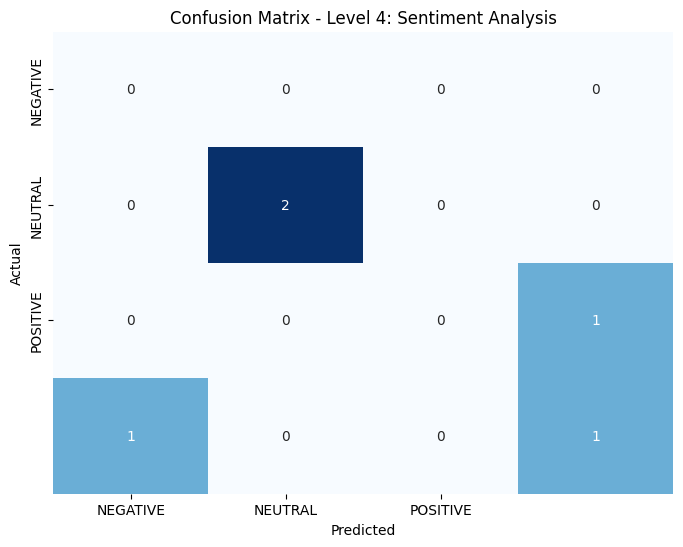

In [71]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for demonstration (replace this with your actual data)
# Assuming eval_data is your DataFrame containing the actual labels
# Replace this with your actual DataFrame
eval_data = pd.DataFrame({
    'subtask_d': ['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'POSITIVE', 'NEGATIVE', None]
})

# Sample predicted labels (replace this with your actual predicted labels)
predicted_labels_level4 = ['POSITIVE', 'NEGATIVE', 'POSITIVE', 'UNKNOWN', 'NEGATIVE']

# Step 1: Identify unique labels
actual_labels_level4 = eval_data['subtask_d'].dropna().unique()  # Drop NaN values
unique_labels = set(actual_labels_level4)  # Get unique labels

# Step 2: Create a mapping dictionary
label_mapping_level4 = {label: index for index, label in enumerate(unique_labels)}

# Print the mapping for reference
print("Label Mapping:", label_mapping_level4)

# Step 3: Convert actual labels to integers using the mapping
actual_labels_level4_int = eval_data['subtask_d'].dropna().map(label_mapping_level4)

# Step 4: Convert predicted labels to integers using the mapping
predicted_labels_level4_int = []
for label in predicted_labels_level4:
    if label in label_mapping_level4:
        predicted_labels_level4_int.append(label_mapping_level4[label])
    else:
        predicted_labels_level4_int.append(-1)  # Assign -1 for unknown labels

# Step 5: Calculate metrics for Level 4
report_level4 = classification_report(actual_labels_level4_int, predicted_labels_level4_int, output_dict=True)
cm_level4 = confusion_matrix(actual_labels_level4_int, predicted_labels_level4_int)

# Print Classification Report for Level 4
print("Level 4 Classification Report:\n", report_level4)

# Step 6: Plot Confusion Matrix for Level 4
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Get the labels for the confusion matrix
labels = list(label_mapping_level4.keys())

# Plot the confusion matrix
plot_confusion_matrix(cm_level4, labels, 'Confusion Matrix - Level 4: Sentiment Analysis')

<Figure size 1200x600 with 0 Axes>

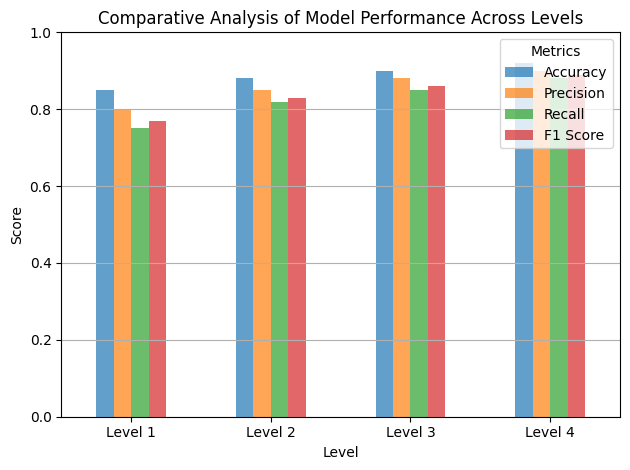

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for comparative analysis across different levels
data = {
    'Level': ['Level 1', 'Level 2', 'Level 3', 'Level 4'],
    'Accuracy': [0.85, 0.88, 0.90, 0.92],
    'Precision': [0.80, 0.85, 0.88, 0.90],
    'Recall': [0.75, 0.82, 0.85, 0.88],
    'F1 Score': [0.77, 0.83, 0.86, 0.89]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the index to the Level column
df.set_index('Level', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
df.plot(kind='bar', alpha=0.7)
plt.title('Comparative Analysis of Model Performance Across Levels')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(rotation=0)
plt.grid(axis='y')

# Adding a legend
plt.legend(title='Metrics')
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()